# Análisis de datos

**Andrés Chaparro** 

**Juan Andrés Bernal**



In [1]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,silhouette_samples, silhouette_score

import scipy.stats as stats

# 1. Carga de datos (csv)
Se cargan la base de datos (txt) para trabajar con estos

In [2]:
direccion_B2C_cotizaciones = 'Datos/base_2_cotizaciones.txt'

data_original_B2C_cotizaciones = pd.read_csv(direccion_B2C_cotizaciones, sep="\t", encoding='utf-8')

print("\nShape of B2C quotations data:", data_original_B2C_cotizaciones.shape) 



Shape of B2C quotations data: (180387, 11)


In [3]:
data_original_B2C_cotizaciones.head()

,cotizacion,estado_cotizacion,id,fecha_creacion,fecha_modificacion,categoria_macro,categoria,producto,cantidad,precio,valor
0,1381861.0,Cotización Ganada,91587,1972-08-05 12:25:47.700,1972-08-05 13:37:35,categoria_macro_4,categoria_9,producto_524,1.0,34.957429,34.957429
1,1381861.0,Cotización Ganada,91587,1972-08-05 12:25:47.700,1972-08-05 13:37:35,categoria_macro_4,categoria_11,producto_124,1.0,2.262000,2.262000
2,1381861.0,Cotización Ganada,91587,1972-08-05 12:25:47.700,1972-08-05 13:37:35,categoria_macro_4,categoria_10,producto_5085,1.0,40.600000,40.600000
3,1381861.0,Cotización Ganada,91587,1972-08-05 12:25:47.700,1972-08-05 13:37:35,categoria_macro_4,categoria_11,producto_188,1.0,7.863143,7.863143
4,1381864.0,Cotización Ganada,93623,1972-08-05 14:36:57.273,1972-08-05 15:06:26,categoria_macro_4,categoria_10,producto_391,1.0,63.932571,63.932571


# 2. Entendimientos de los datos 

In [4]:
data_original_B2C_cotizaciones.describe()

,cotizacion,id,cantidad,precio,valor
count,1.803870e+05,180387.000000,180387.000000,180387.000000,180387.000000
mean,5.078489e+06,201958.376563,30.337815,18.897239,36.905377
std,2.330758e+06,131817.410108,1128.197335,43.212077,884.640566
min,1.330102e+06,9.000000,0.000000,0.000000,0.000000
25%,3.014320e+06,90794.500000,1.000000,1.702715,2.850289
50%,4.625202e+06,156082.000000,1.000000,6.844000,9.495428
75%,7.073812e+06,357146.000000,2.000000,19.214571,27.657714
max,9.660005e+06,429016.000000,438000.000000,3087.911715,366411.673079


In [5]:
# Para variables numéricas (continuas)
continuous_vars = data_original_B2C_cotizaciones.select_dtypes(include=['int64', 'float64'])
print(f"Número de variables continuas: {len(continuous_vars.columns)}")

# Para variables categóricas
categorical_vars = data_original_B2C_cotizaciones.select_dtypes(include=['object', 'category'])
print(f"Número de variables categóricas: {len(categorical_vars.columns)}")

# Para mostrar cuáles son las variables categóricas
print("\nVariables categóricas:")
for col in categorical_vars.columns:
    unique_values = len(data_original_B2C_cotizaciones[col].unique())
    print(f"- {col}: {unique_values} categorías únicas")

Número de variables continuas: 5
Número de variables categóricas: 6

Variables categóricas:
- estado_cotizacion: 4 categorías únicas
- fecha_creacion: 88028 categorías únicas
- fecha_modificacion: 87589 categorías únicas
- categoria_macro: 4 categorías únicas
- categoria: 14 categorías únicas
- producto: 2735 categorías únicas


In [6]:
# Obtener el conteo de cada categoría en estado_cotizacion
print("\nCategorías en estado_cotizacion:")
print(data_original_B2C_cotizaciones['estado_cotizacion'].value_counts())



Categorías en estado_cotizacion:
estado_cotizacion
Cotización Ganada      140116
Cotización Expirada     28626
Abierta                  5831
Cotización Perdida       5814
Name: count, dtype: int64


In [7]:
# Obtener el conteo de cada categoría en estado_cotizacion
print("\nCategorías en Producto:")
print(data_original_B2C_cotizaciones['producto'].value_counts())



Categorías en Producto:
producto
producto_28      5603
producto_277     5345
producto_4637    2862
producto_188     2822
producto_27      2789
                 ... 
producto_5634       1
producto_6654       1
producto_6272       1
producto_3854       1
producto_7132       1
Name: count, Length: 2735, dtype: int64


### 2.1 Datos Nulos

In [8]:
features = data_original_B2C_cotizaciones.columns
print("\nCantidad de datos nulos:")
data_original_B2C_cotizaciones[features].isnull().sum() 


Cantidad de datos nulos:


cotizacion            0
estado_cotizacion     0
id                    0
fecha_creacion        0
fecha_modificacion    0
categoria_macro       0
categoria             0
producto              0
cantidad              0
precio                0
valor                 0
dtype: int64

### 2.2 HeatMap de Correlaciones

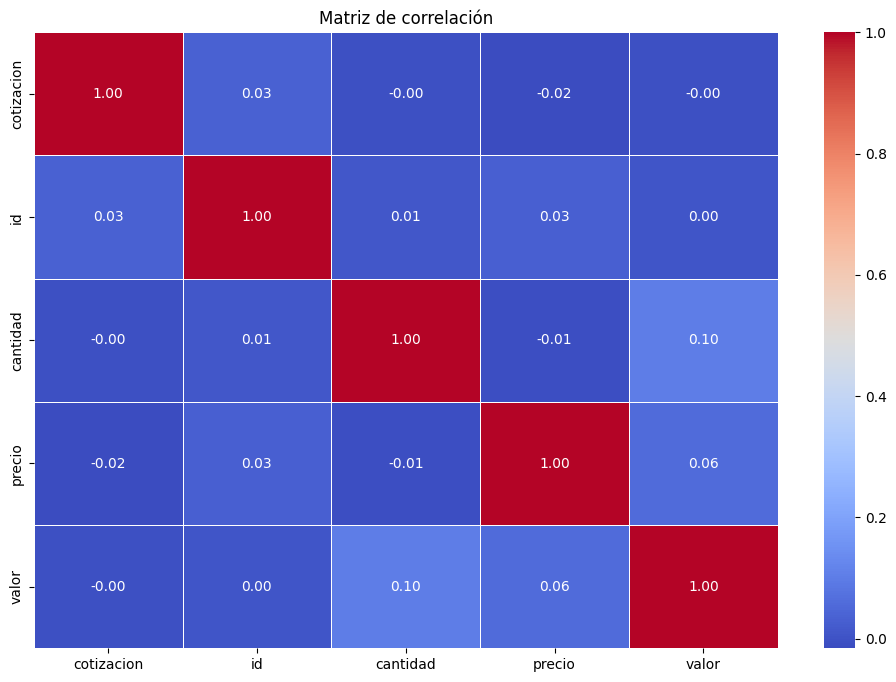

In [9]:
numeric_columns = data_original_B2C_cotizaciones.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 8))
sns.heatmap(data_original_B2C_cotizaciones[numeric_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación")
plt.show()


# Limpieza de datos

In [10]:
import numpy as np
import pandas as pd

# Función para contar outliers usando IQR
def contar_outliers_iqr(df):
    outliers_por_variable = {}
    
    for columna in df.select_dtypes(include=np.number):  # Solo variables numéricas
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
        outliers_por_variable[columna] = len(outliers)
    
    return outliers_por_variable

# Contar outliers en cada variable de datos_limpios2
outliers = contar_outliers_iqr(data_original_B2C_cotizaciones)

# Mostrar resultados en un DataFrame
df_outliers = pd.DataFrame(outliers.items(), columns=["Variable", "Cantidad de Outliers"])
df_outliers["Porcentaje de Outliers"] = (df_outliers["Cantidad de Outliers"] / len(data_original_B2C_cotizaciones) * 100).round(2)
df_outliers


,Variable,Cantidad de Outliers,Porcentaje de Outliers
0,cotizacion,0,0.00
1,id,0,0.00
2,cantidad,16787,9.31
3,precio,17267,9.57
4,valor,19433,10.77


# Ingenieria de Caracteres

In [11]:
data_original_B2C_cotizaciones.head(1)

,cotizacion,estado_cotizacion,id,fecha_creacion,fecha_modificacion,categoria_macro,categoria,producto,cantidad,precio,valor
0,1381861.0,Cotización Ganada,91587,1972-08-05 12:25:47.700,1972-08-05 13:37:35,categoria_macro_4,categoria_9,producto_524,1.0,34.957429,34.957429


In [12]:
df_productos = data_original_B2C_cotizaciones.groupby('producto').agg(
    total_cotizaciones=('producto', 'count'),
    cot_ganada=('estado_cotizacion', lambda x: (x == 'Cotización Ganada').sum()),
    cot_expirada=('estado_cotizacion', lambda x: (x == 'Cotización Expirada').sum()),
    cot_abierta=('estado_cotizacion', lambda x: (x == 'Abierta').sum()),
    cot_perdida=('estado_cotizacion', lambda x: (x == 'Cotización Perdida').sum())
).reset_index()


In [13]:
# Ordenar productos por total de cotizaciones de mayor a menor
productos_mas_cotizados = df_productos.sort_values('total_cotizaciones', ascending=False)

# Mostrar los 10 productos más cotizados
print("Los 10 productos más cotizados:")
print(productos_mas_cotizados.head(10))


Los 10 productos más cotizados:
           producto  total_cotizaciones  cot_ganada  cot_expirada  \
782     producto_28                5603        4903           437   
766    producto_277                5345        4477           591   
1563  producto_4637                2862        2593           172   
379    producto_188                2822        2247           400   
730     producto_27                2789        2414           225   
872     producto_30                2636        2128           329   
579    producto_238                2280        1872           307   
2654   producto_847                2256        1701           396   
2368   producto_648                2219        1761           304   
94     producto_124                1802        1438           269   

      cot_abierta  cot_perdida  
782            98          165  
766           125          152  
1563           50           47  
379            90           85  
730            47          103  
872       